# Using Progressive Growing GAN

Today we will show some basic commands to use Progressive GAN.

## 0 Prepare libraries

In [1]:
%tensorflow_version 1.x

!pip install -U -q PyDrive
!git clone https://github.com/tkarras/progressive_growing_of_gans.git
!pip install numpy==1.16
!pip install tqdm
%cd progressive_growing_of_gans

TensorFlow 1.x selected.
Cloning into 'progressive_growing_of_gans'...
remote: Enumerating objects: 155, done.
remote: Total 155 (delta 0), reused 0 (delta 0), pack-reused 155
Receiving objects: 100% (155/155), 350.61 KiB | 25.04 MiB/s, done.
Resolving deltas: 100% (79/79), done.
     |████████████████████████████████| 17.3MB 200kB/s 
ERROR: tensorflow 1.15.2 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: umap-learn 0.4.3 has requirement numpy>=1.17, but you'll have numpy 1.16.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.4
    Uninstalling numpy-1.18.4:
      Successfully uninstalled numpy-1.18.4


/content/progressive_growing_of_gans


In [2]:
import tensorflow
print(tensorflow.__version__)

1.15.2


In [3]:
!nvidia-smi

Fri May 29 12:57:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '188K19ucknC6wg1R6jbuPEhTq9zoufOx4' # karras2018iclr-celebahq-1024x1024.pkl 
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('karras2018iclr-celebahq-1024x1024.pkl')

In [0]:
# CHECK MORE MODELS from the original ProgressiveGAN paper: https://drive.google.com/drive/folders/15hvzxt_XxuokSmj0uO4xxMTMWVc0cIMU

# https://drive.google.com/file/d/1xl6igEIL0N_wSLAocD6lyvTCsHkpRY88/view?usp=sharing
file_id = '1xl6igEIL0N_wSLAocD6lyvTCsHkpRY88'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('car.pkl')

In [6]:
!ls

car.pkl				       misc.py
config.py			       networks.py
dataset.py			       README.md
dataset_tool.py			       representative_image_512x256.png
karras2018iclr-celebahq-1024x1024.pkl  requirements-pip.txt
legacy.py			       tfutil.py
LICENSE.txt			       train.py
loss.py				       util_scripts.py
metrics


## 1 Basic inference

In [0]:
model_path = 'car.pkl'

In [80]:
import pickle, pickletools
import numpy as np
import tensorflow as tf
import PIL.Image

# Initialize TensorFlow session.
tf.InteractiveSession()
#sess=tf.compat.v1.InteractiveSession()


# Import official CelebA-HQ networks.
with open(model_path, 'rb') as file:
    print(file)
    
    proto_op = next(pickletools.genops(file))
    assert proto_op[0].name == 'PROTO'
    proto_ver = proto_op[1]
    print("Pickled with version", proto_ver)

    G, D, Gs = pickle.load(file)

/tensorflow-1.15.2/python3.6/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


<_io.BufferedReader name='car.pkl'>
Pickled with version 4


In [81]:
print(G)
print(D)
print(Gs)

In [0]:
import matplotlib.pyplot as plt

def generate_latents2image(latents):
    latents = np.asarray(latents)

    labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])

    # Run the generator to produce a set of images.
    images = Gs.run(latents, labels)

    # Convert images to PIL-compatible format.
    images = np.clip(np.rint((images + 1.0) / 2.0 * 255.0), 0.0, 255.0).astype(np.uint8) # [-1,1] => [0,255]
    images = images.transpose(0, 2, 3, 1) # NCHW => NHWC
    return images

def show_image(image, figsize=(4,4)):
    print(image.shape, "stats:", np.max(image), np.min(image), np.mean(image))

    plt.figure(figsize=figsize)
    plt.imshow(image, vmin=0.0, vmax=1.0)
    plt.show()

(256, 256, 3)
(256, 256, 3) stats: 255 0 89.91055297851562


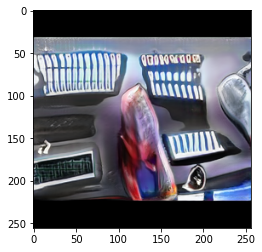

In [83]:
latent = np.random.randn((512))
images = generate_latents2image([latent])
image = images[0]
print(image.shape)
show_image(image)

## 2 Latent vector interpolation

In [0]:
import math
import numpy as np
def interpolate_vectors(vectors, desired_number):
    vectors = np.asarray(vectors)
    num_of_vectors = len(vectors)
    num_of_segments = num_of_vectors - 1

    each_segment = math.floor( (desired_number-1) / (num_of_vectors-1) )

    segments = [each_segment] * num_of_segments

    i = 0
    while sum(segments) < (desired_number-1):
        segments[i] += 1
        i += 1

    print("segments:",segments,"+1 last vec")
    interpolated_vectors = []
    for nth, segment in enumerate(segments):
        v1 = vectors[nth]
        v2 = vectors[nth+1]
        for i in range(0,segment):
            k = (float(i)/float(segment))
            vec = v1 + k * (v2 - v1)
            interpolated_vectors.append(np.array(vec))

    interpolated_vectors.append(vectors[-1]) # end with the last one

    #print(len(interpolated_vectors), interpolated_vectors)
    interpolated_vectors = np.asarray(interpolated_vectors)
    return interpolated_vectors

In [85]:
latent_1 = np.random.randn((512))
latent_2 = np.random.randn((512))

# Interpolation:
latents = interpolate_vectors([latent_1, latent_2], 10)
print(latents.shape)

segments: [9] +1 last vec
(10, 512)


In [0]:
def lerp(u,v,a):
    return a*u + (1-a)*v

w = lerp(latent_1,latent_2,0.5)

In [58]:
print(latent_1.shape)
print(w.shape)
print(latent_2.shape)

(512,)
(512,)
(512,)


In [86]:
images = generate_latents2image(latents)
print(images.shape)

(10, 256, 256, 3)


In [0]:
# Image concatenation:
# horizontal = np.concatenate((image1, image2), axis = 1)
# vertical = np.concatenate((image1, image2), axis = 0)

(256, 2560, 3)
(256, 2560, 3) stats: 255 0 141.07734069824218


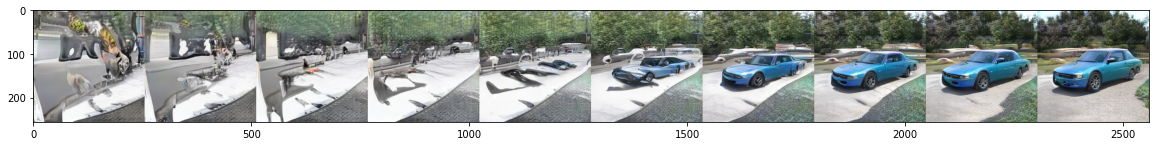

In [87]:
horizontal = np.concatenate((images), axis = 1)
print(horizontal.shape)
show_image(horizontal, figsize=(20,20))

segments: [9] +1 last vec
segments: [9] +1 last vec
(512, 2560, 3) stats: 255 0 113.04293467203776


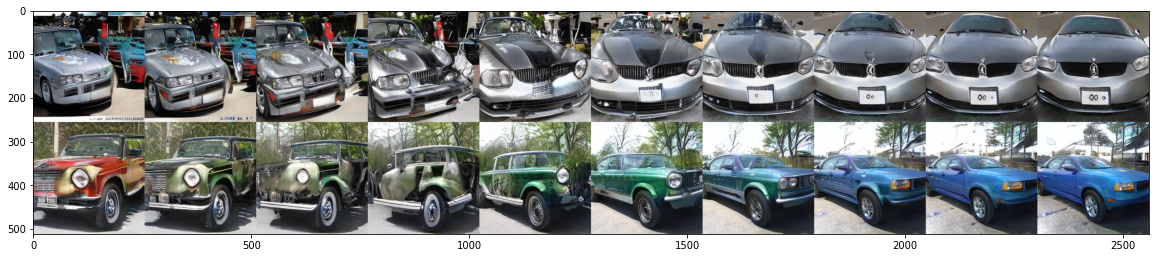

In [91]:
latent_1 = np.random.randn((512))
latent_2 = np.random.randn((512))
latents = interpolate_vectors([latent_1, latent_2], 10)
images = generate_latents2image(latents)
horizontalA = np.concatenate((images), axis = 1)

latent_1 = np.random.randn((512))
latent_2 = np.random.randn((512))
latents = interpolate_vectors([latent_1, latent_2], 10)
images = generate_latents2image(latents)
horizontalB = np.concatenate((images), axis = 1)

# etc ...

grid = np.concatenate((horizontalA, horizontalB), axis = 0)
show_image(grid, figsize=(20,20))

## 3 Saving generated images

In [0]:
def save_image(image, name):
    PIL.Image.fromarray(image, 'RGB').save(name)

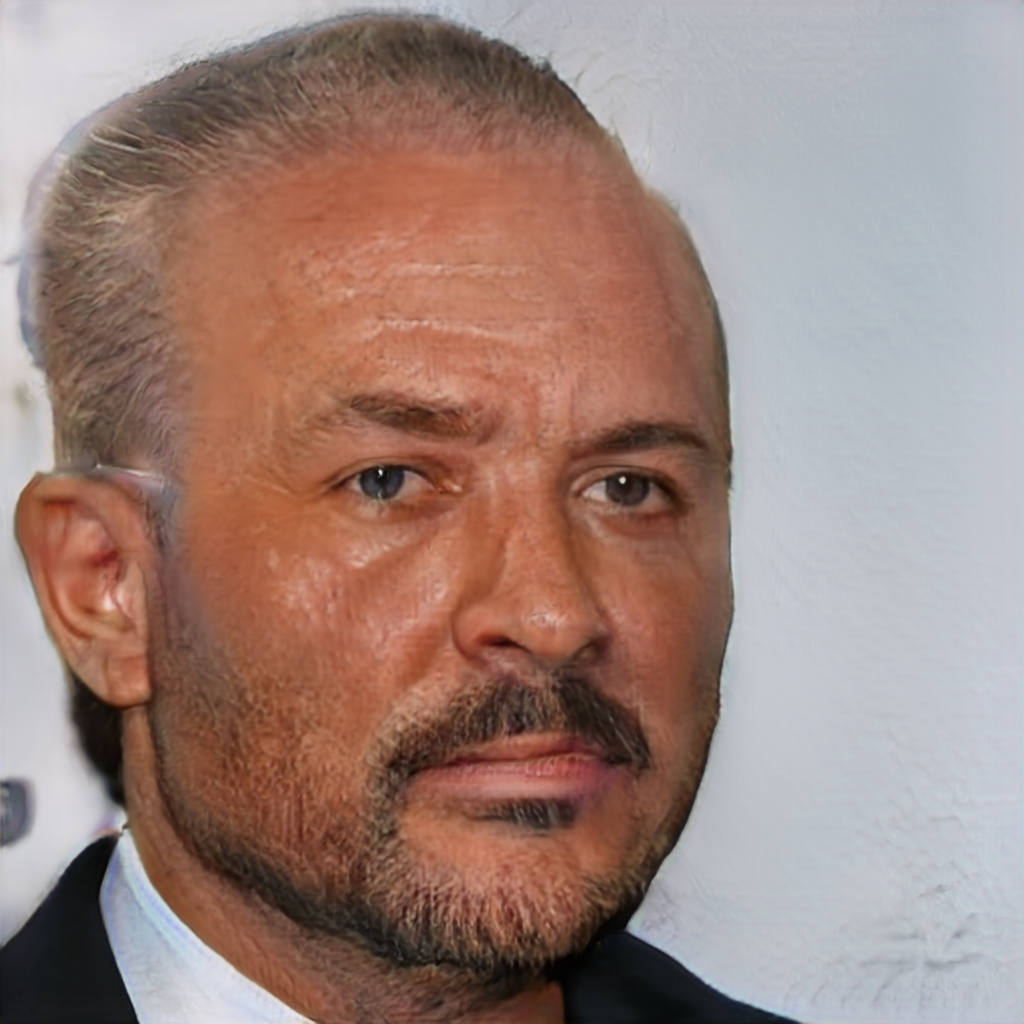

In [72]:
save_image(images[3], "test.png")

from IPython.display import Image
Image("test.png", width=512)

In [0]:
!mkdir renders

In [0]:
# Save images as PNG.
name = "renders/faces_"
for idx in range(images.shape[0]):
    save_image(images[idx], name+str(idx).zfill(3)+'.png')  

In [75]:
!ls renders

faces_000.png  faces_002.png  faces_004.png  faces_006.png  faces_008.png
faces_001.png  faces_003.png  faces_005.png  faces_007.png  faces_009.png


In [0]:
# then zip and download the usual way ...

## 4 Interpolation video

In [0]:
from tqdm import tqdm
import cv2
def make_video(images, outvid = "out.mp4", outimg=None, fps=5, size=None,
               is_color=True, format="XVID"):
    """
    Create a video from a list of images.
 
    @param      outvid      output video
    @param      images      list of images to use in the video
    @param      fps         frame per second
    @param      size        size of each frame
    @param      is_color    color
    @param      format      see http://www.fourcc.org/codecs.php
    @return                 see http://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html
 
    The function relies on http://opencv-python-tutroals.readthedocs.org/en/latest/.
    By default, the video will have the size of the first image.
    It will resize every image to this size before adding them to the video.
    """
    from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize
    fourcc = VideoWriter_fourcc(*format)
    vid = None
    
    
    for image in tqdm(images):
        img = image # img = imread(image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #print(img.shape)
        if vid is None:
            if size is None:
                size = img.shape[1], img.shape[0]
            vid = VideoWriter(outvid, fourcc, float(fps), size, is_color)
        if size[0] != img.shape[1] and size[1] != img.shape[0]:
            img = resize(img, size)
        vid.write(img)
    vid.release()
    return vid

In [77]:
make_video(images, "out.mp4", fps=5)

100%|██████████| 10/10 [00:00<00:00, 25.81it/s]


<VideoWriter 0x7f8889f64210>

In [78]:
!ls -luah out.mp4

-rw-r--r-- 1 root root 513K May 29 13:21 out.mp4
